# Imports

In [1]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

import shap

%matplotlib inline

Dataset reference:

- Anselin, D. L., et al. (2003). Geoda. geodacenter.github.io.    

In [2]:
data = pd.read_csv('src/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [3]:
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

# How to compute SHAP values
$\phi_i \rightarrow$ Shapley value for feature $i$ **(e.g.: {Bedrooms})**<br>
$f \rightarrow$ Black Box Model<br>
$x \rightarrow$ Input data point<br>
$z' \rightarrow$ Subset **(e.g.: {Bedrooms, Bathrooms})**<br>
$x' \rightarrow$ Simplified data input<br>
Using a **mapping function** we transform $x \rightarrow x'$ <br>
$z'\subseteq x' \rightarrow$ Iterate over all possible combinations of features<br>
$f_x(z') \rightarrow$ Black Box Model output for our input **with** the feature(s) we are interested in **(e.g.:{Bedrooms, Bathrooms})**<br>
$f_x(z' \backslash i) \rightarrow$ Black Box Model output for our input **without** the feature(s) we are interested in **(e.g.:{Bedrooms})**<br>
$[f_x(z') - f_x(z' \backslash i)] \rightarrow$ Tells us how feature $i$ contributed to that subset. Also called the **marginal value**<br>
$M \rightarrow$ Total number of features<br>
$\frac{|z'|!(M - |z'| - 1)!}{M!} \rightarrow$ Weighting according to how many players are in that correlation<br><br>
$$\phi_i(f,x) = \sum_{z'\subseteq x'} \frac{|z'|!(M - |z'| - 1)!}{M!} [f_x(z') - f_x(z' \backslash i)]$$

## Reduce the data

In [4]:
subdata = data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']]

## Compute all possible coalitions

$$z' \subseteq x'$$

In [5]:
from itertools import combinations

# Gets all the possible combinations of the sample, 
# without the feature that is specified
def get_coalitions(sample, feature):
    
    # get the rest of the features
    rest_features = []
    for feat in sample.index:
        if feat != feature:
            rest_features.append(feat)
            
    # get all possible coalitions for every amount of features
    coalition_list = []
    for feat_num in range(len(sample.index)):
        for coalition in combinations(rest_features,feat_num):
            coalition_list.append(list(coalition))
    
    return coalition_list

- Amount of coalitions is $(2^{rest\_features}-1)$

In [6]:
sample = subdata.iloc[0]
feature = 'bedrooms'
sample

bedrooms          3.0
bathrooms         1.0
sqft_living    1180.0
sqft_lot       5650.0
Name: 0, dtype: float64

In [7]:
print('Coalitions of 3 features = ', 2**3-1, 'combinations')
get_coalitions(sample, feature)

Coalitions of 3 features =  7 combinations


[[],
 ['bathrooms'],
 ['sqft_living'],
 ['sqft_lot'],
 ['bathrooms', 'sqft_living'],
 ['bathrooms', 'sqft_lot'],
 ['sqft_living', 'sqft_lot'],
 ['bathrooms', 'sqft_living', 'sqft_lot']]

## Get contribution of a coalition

$$\frac{|z'|!(M - |z'| - 1)!}{M!}[f_x(z') - f_x(z' \backslash i)]$$

### Get Output of an arrangement of features

$$f_x(z')$$

In [8]:
def get_val(model, background, sample, coalition):
    
    # get coalition feature values and map them to a dictionary
    coalition_features = {c: sample[c] for c in coalition} 
    
    # features 'present' in coalition get assigned to all to all 
    # background with their corresponding features.
    # get the mean over all predictions
    return model.predict(background.assign( \
                                    **coalition_features)).mean()

In [9]:
from sklearn.linear_model import LinearRegression

X = subdata.iloc[0:100]
y = data['price'].iloc[0:100]
linear_model = LinearRegression()
linear_model.fit(X, y)

LinearRegression()

In [10]:
sample = subdata.iloc[101]
# subset of features z'
coalition = ['sqft_living', 'sqft_lot']
val = get_val(linear_model, X, sample, coalition)

print('sample =', list(sample))
print('y value = ', data['price'].iloc[101])
print('y predicted = ', val)
print('linear model pred = ', linear_model.predict(subdata.iloc[101:102]))

sample = [3.0, 2.0, 1980.0, 3478.0]
y value =  555000.0
y predicted =  464752.70933984814
linear model pred =  [459453.44594042]


### Get feature contribution for all equal coalitions



$$\frac{|z'|!(M - |z'| - 1)!}{M!}[f_x(z') - f_x(z' \backslash i)]$$



In [11]:
from math import factorial

# val(S U i) - val(S)
def get_contributions(model, background, sample, feat, coalition):
    
    # val(S U i) == f_x(z')
    val_s_i = get_val(model, background, sample, coalition + [feat])
    # val(S) == f_x(z'\ i)
    val_s = get_val(model, background, sample, coalition)
    
    ## get worth of coalition : val(S U i) - val(S)
    val = val_s_i - val_s
    
    ## get number of coalitions
    z = len(coalition) # number of present features in coalition
    M = len(sample.index) # number of total features
    num_coalitions = (factorial(z)*factorial(M - z - 1)) / factorial(M)

    return num_coalitions * val  

In [12]:
feature = 'bathrooms'
coalition = ['sqft_living', 'sqft_lot']
get_contributions(linear_model, X, sample, feature, coalition)

-21.805124883166474

# Computing SHAP: putting it all together

$$\phi_i(f,x) = \sum_{z'\subseteq x'} \frac{|z'|!(M - |z'| - 1)!}{M!} [f_x(z') - f_x(z' \backslash i)]$$

In [13]:
def calculateSHAP(model, background, X):
    shap_values = []
    #for every sample
    for i in range(np.shape(X)[0]):
        sample = X.iloc[i]
        # 1. calculate coalitions\
        # for every feature
        shap_vals_for_x = []
        for feat in X.columns:
            coalitions = get_coalitions(sample, feat)
            contributions = []
            for coalition in coalitions:
                contributions.append(get_contributions(model, 
                                                    background,
                                                     sample, 
                                                     feat,
                                                     coalition))
            shap_val = np.sum(contributions)
            shap_vals_for_x.append(shap_val)
        shap_values.append(shap_vals_for_x)
    base_val = np.average(model.predict(background))
    return base_val, shap_values

In [14]:
calculateSHAP(linear_model, subdata.iloc[0:100], 
              subdata.iloc[101:102])

(519149.3500000001,
 [[-5037.601900831834,
   -261.6614985980268,
   -24785.54102795609,
   -29611.099632195797]])

In [15]:
import shap
# 0:100 as background
explainer = shap.Explainer(linear_model, subdata.iloc[0:100])
shap_values = explainer(subdata.iloc[101:102])
shap_values

.values =
array([[ -5037.60190083,   -261.6614986 , -24785.54102796,
        -29611.0996322 ]])

.base_values =
array([519149.35])

.data =
array([[3.000e+00, 2.000e+00, 1.980e+03, 3.478e+03]])

# Show Test Case
- House price dataset 

In [16]:
# Getting rid of irrelevant features
data = data.drop(['id', 'date'], axis=1)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


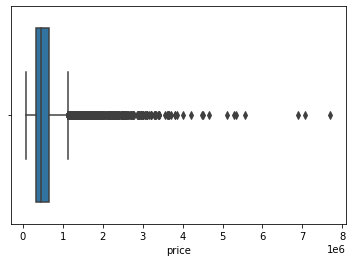

Data distribution: price
(67374.999, 837500.0]     19022
(837500.0, 1600000.0]      2165
(1600000.0, 2362500.0]      298
(2362500.0, 3125000.0]       90
(3125000.0, 3887500.0]       26
(3887500.0, 4650000.0]        4
(4650000.0, 5412500.0]        4
(5412500.0, 6175000.0]        1
(6175000.0, 6937500.0]        1
(6937500.0, 7700000.0]        2
Name: price, dtype: int64
Min 75000.0
Max 7700000.0





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


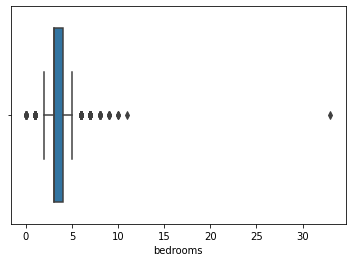

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Data distribution: bedrooms
(-0.034, 3.3]    12796
(3.3, 6.6]        8755
(6.6, 9.9]          57
(9.9, 13.2]          4
(13.2, 16.5]         0
(16.5, 19.8]         0
(19.8, 23.1]         0
(23.1, 26.4]         0
(26.4, 29.7]         0
(29.7, 33.0]         1
Name: bedrooms, dtype: int64
Min 0
Max 33





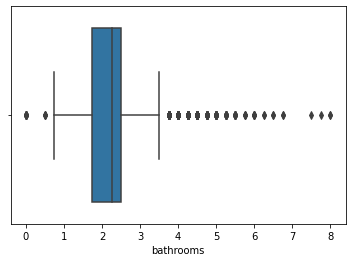

Data distribution: bathrooms
(-0.009000000000000001, 0.8]      86
(0.8, 1.6]                      5307
(1.6, 2.4]                      7025
(2.4, 3.2]                      7318
(3.2, 4.0]                      1611
(4.0, 4.8]                       202
(4.8, 5.6]                        44
(5.6, 6.4]                        12
(6.4, 7.2]                         4
(7.2, 8.0]                         4
Name: bathrooms, dtype: int64
Min 0.0
Max 8.0





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


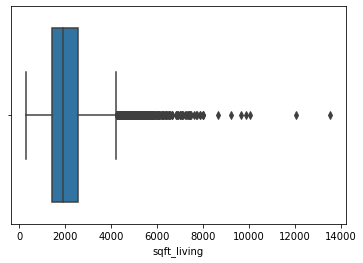

Data distribution: sqft_living
(276.749, 1615.0]      7570
(1615.0, 2940.0]      10714
(2940.0, 4265.0]       2780
(4265.0, 5590.0]        441
(5590.0, 6915.0]         77
(6915.0, 8240.0]         24
(8240.0, 9565.0]          2
(9565.0, 10890.0]         3
(10890.0, 12215.0]        1
(12215.0, 13540.0]        1
Name: sqft_living, dtype: int64
Min 290
Max 13540





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


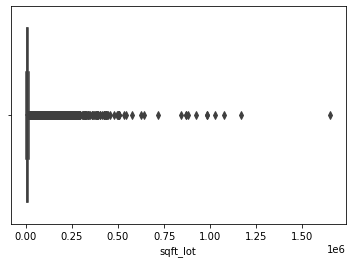

Data distribution: sqft_lot
(-1130.84, 165603.9]      21303
(165603.9, 330687.8]        251
(330687.8, 495771.7]         37
(495771.7, 660855.6]         10
(660855.6, 825939.5]          1
(825939.5, 991023.4]          7
(991023.4, 1156107.3]         2
(1156107.3, 1321191.2]        1
(1321191.2, 1486275.1]        0
(1486275.1, 1651359.0]        1
Name: sqft_lot, dtype: int64
Min 520
Max 1651359





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


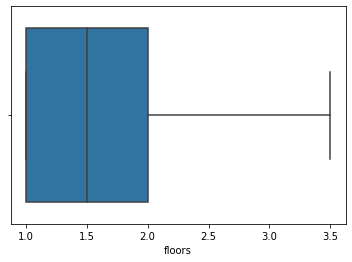

Data distribution: floors
(0.997, 1.25]    10680
(1.25, 1.5]       1910
(1.5, 1.75]          0
(1.75, 2.0]       8241
(2.0, 2.25]          0
(2.25, 2.5]        161
(2.5, 2.75]          0
(2.75, 3.0]        613
(3.0, 3.25]          0
(3.25, 3.5]          8
Name: floors, dtype: int64
Min 1.0
Max 3.5





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


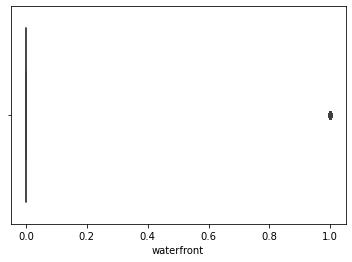

Data distribution: waterfront
(-0.002, 0.1]    21450
(0.1, 0.2]           0
(0.2, 0.3]           0
(0.3, 0.4]           0
(0.4, 0.5]           0
(0.5, 0.6]           0
(0.6, 0.7]           0
(0.7, 0.8]           0
(0.8, 0.9]           0
(0.9, 1.0]         163
Name: waterfront, dtype: int64
Min 0
Max 1





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


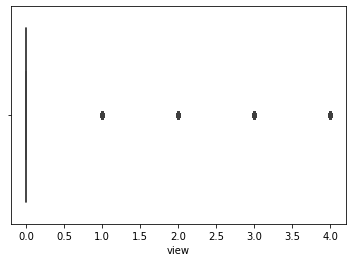

Data distribution: view
(-0.005, 0.4]    19489
(0.4, 0.8]           0
(0.8, 1.2]         332
(1.2, 1.6]           0
(1.6, 2.0]         963
(2.0, 2.4]           0
(2.4, 2.8]           0
(2.8, 3.2]         510
(3.2, 3.6]           0
(3.6, 4.0]         319
Name: view, dtype: int64
Min 0
Max 4





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


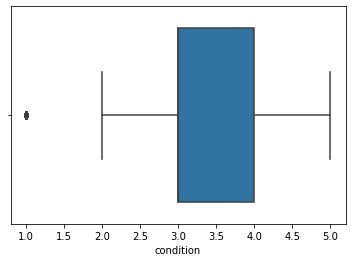

Data distribution: condition
(0.995, 1.4]       30
(1.4, 1.8]          0
(1.8, 2.2]        172
(2.2, 2.6]          0
(2.6, 3.0]      14031
(3.0, 3.4]          0
(3.4, 3.8]          0
(3.8, 4.2]       5679
(4.2, 4.6]          0
(4.6, 5.0]       1701
Name: condition, dtype: int64
Min 1
Max 5





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


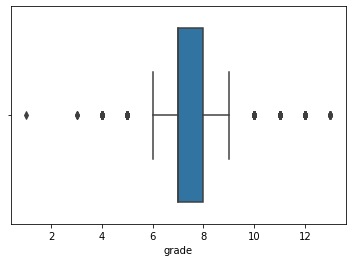

Data distribution: grade
(0.987, 2.2]        1
(2.2, 3.4]          3
(3.4, 4.6]         29
(4.6, 5.8]        242
(5.8, 7.0]      11019
(7.0, 8.2]       6068
(8.2, 9.4]       2615
(9.4, 10.6]      1134
(10.6, 11.8]      399
(11.8, 13.0]      103
Name: grade, dtype: int64
Min 1
Max 13





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


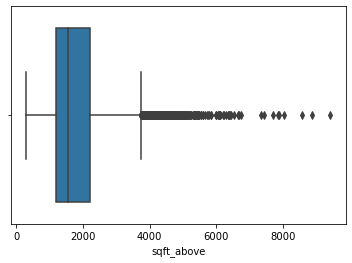

Data distribution: sqft_above
(280.879, 1202.0]    5621
(1202.0, 2114.0]     9988
(2114.0, 3026.0]     4065
(3026.0, 3938.0]     1483
(3938.0, 4850.0]      352
(4850.0, 5762.0]       69
(5762.0, 6674.0]       25
(6674.0, 7586.0]        3
(7586.0, 8498.0]        4
(8498.0, 9410.0]        3
Name: sqft_above, dtype: int64
Min 290
Max 9410





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


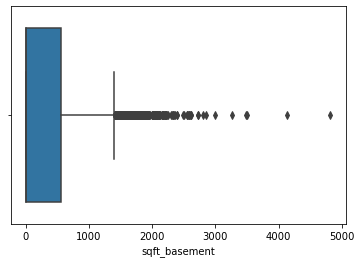

Data distribution: sqft_basement
(-4.821000000000001, 482.0]    15556
(482.0, 964.0]                  3884
(964.0, 1446.0]                 1732
(1446.0, 1928.0]                 350
(1928.0, 2410.0]                  71
(2410.0, 2892.0]                  14
(2892.0, 3374.0]                   2
(3374.0, 3856.0]                   2
(3856.0, 4338.0]                   1
(4338.0, 4820.0]                   1
Name: sqft_basement, dtype: int64
Min 0
Max 4820





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


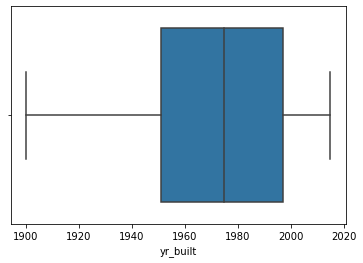

Data distribution: yr_built
(1899.884, 1911.5]     852
(1911.5, 1923.0]       952
(1923.0, 1934.5]      1079
(1934.5, 1946.0]      1361
(1946.0, 1957.5]      2587
(1957.5, 1969.0]      3218
(1969.0, 1980.5]      2525
(1980.5, 1992.0]      2784
(1992.0, 2003.5]      2663
(2003.5, 2015.0]      3592
Name: yr_built, dtype: int64
Min 1900
Max 2015





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


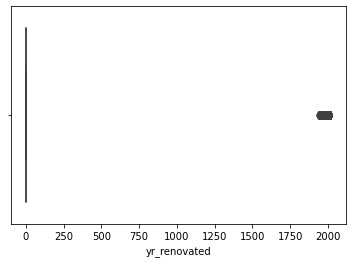

Data distribution: yr_renovated
(-2.016, 201.5]     20699
(201.5, 403.0]          0
(403.0, 604.5]          0
(604.5, 806.0]          0
(806.0, 1007.5]         0
(1007.5, 1209.0]        0
(1209.0, 1410.5]        0
(1410.5, 1612.0]        0
(1612.0, 1813.5]        0
(1813.5, 2015.0]      914
Name: yr_renovated, dtype: int64
Min 0
Max 2015





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


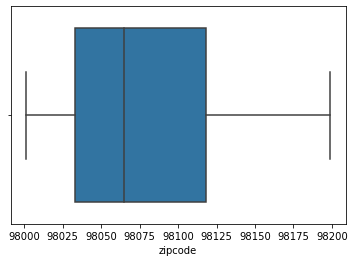

Data distribution: zipcode
(98000.80099999999, 98020.8]    2857
(98020.8, 98040.6]              4384
(98040.6, 98060.4]              3345
(98060.4, 98080.2]              1699
(98080.2, 98100.0]               351
(98100.0, 98119.8]              4259
(98119.8, 98139.6]              1811
(98139.6, 98159.4]              1134
(98159.4, 98179.2]              1040
(98179.2, 98199.0]               733
Name: zipcode, dtype: int64
Min 98001
Max 98199





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


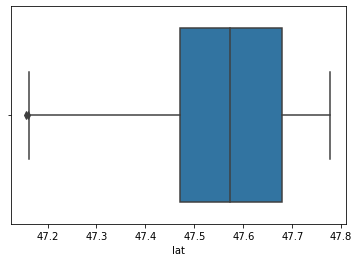

Data distribution: lat
(47.154, 47.218]     181
(47.218, 47.28]      329
(47.28, 47.342]     1428
(47.342, 47.405]    1930
(47.405, 47.467]    1432
(47.467, 47.529]    2584
(47.529, 47.591]    3866
(47.591, 47.653]    3004
(47.653, 47.715]    4021
(47.715, 47.778]    2838
Name: lat, dtype: int64
Min 47.1559
Max 47.7776





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


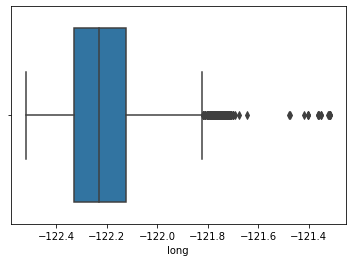

Data distribution: long
(-122.521, -122.399]     419
(-122.399, -122.278]    8832
(-122.278, -122.158]    5644
(-122.158, -122.037]    3908
(-122.037, -121.917]    2091
(-121.917, -121.797]     483
(-121.797, -121.676]     217
(-121.676, -121.556]       2
(-121.556, -121.435]       2
(-121.435, -121.315]      15
Name: long, dtype: int64
Min -122.519
Max -121.315





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


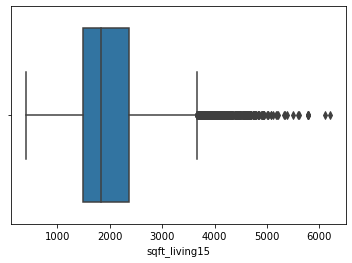

Data distribution: sqft_living15
(393.18800000000005, 980.1]     312
(980.1, 1561.2]                6440
(1561.2, 2142.3]               7587
(2142.3, 2723.4]               4200
(2723.4, 3304.5]               2004
(3304.5, 3885.6]                731
(3885.6, 4466.7]                235
(4466.7, 5047.8]                 84
(5047.8, 5628.9]                 12
(5628.9, 6210.0]                  8
Name: sqft_living15, dtype: int64
Min 399
Max 6210





Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


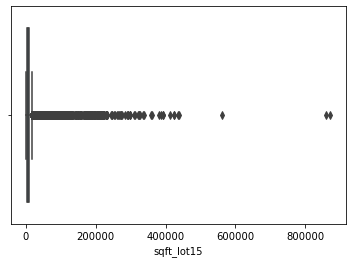

Data distribution: sqft_lot15
(-219.55, 87705.9]      21216
(87705.9, 174760.8]       196
(174760.8, 261815.7]      166
(261815.7, 348870.6]       21
(348870.6, 435925.5]       10
(435925.5, 522980.4]        1
(522980.4, 610035.3]        1
(610035.3, 697090.2]        0
(697090.2, 784145.1]        0
(784145.1, 871200.0]        2
Name: sqft_lot15, dtype: int64
Min 651
Max 871200





In [17]:
import seaborn as sns
for col in data.columns:
    sns.boxplot(data[col])
    plt.show()
    print('Data distribution:', col)
    print(data[col].value_counts(bins = 10, sort=False))
    print('Min', min(data[col]))
    print('Max', max(data[col]))
    print('\n\n')

In [18]:
# Getting rid of price outliers
data = data.drop(data[data.price > 1585000.0].index) # rid of 12 incredibly high outliers

In [19]:
# Getting rid of sqft_living outliers
data = data.drop(data[data.sqft_living > 8000.0].index) 

In [20]:
# Getting rid of sqft_lot outliers
data = data.drop(data[data.sqft_lot > 600000.0].index) 

In [21]:
# Getting rid of sqft_above outliers
data = data.drop(data[data.sqft_above > 8000.0].index) 

In [22]:
# Getting rid of sqft_basement outliers
data = data.drop(data[data.sqft_basement > 3000.0].index) 

In [23]:
# Getting rid of sqft_lot15 outliers
data = data.drop(data[data.sqft_lot15 > 500000.0].index) 

In [24]:
# Since most of the yr_renovated is has 0 values, 
# the data will be transformed to boolean (yr_renovated to renovated)
data['yr_renovated'] = pd.Series(np.where(data.yr_renovated.values > 0, 1, 0),
          data.index)
data.rename(columns = {'yr_renovated':'renovated'}, inplace = True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21150 non-null  float64
 1   bedrooms       21150 non-null  int64  
 2   bathrooms      21150 non-null  float64
 3   sqft_living    21150 non-null  int64  
 4   sqft_lot       21150 non-null  int64  
 5   floors         21150 non-null  float64
 6   waterfront     21150 non-null  int64  
 7   view           21150 non-null  int64  
 8   condition      21150 non-null  int64  
 9   grade          21150 non-null  int64  
 10  sqft_above     21150 non-null  int64  
 11  sqft_basement  21150 non-null  int64  
 12  yr_built       21150 non-null  int64  
 13  renovated      21150 non-null  int64  
 14  zipcode        21150 non-null  int64  
 15  lat            21150 non-null  float64
 16  long           21150 non-null  float64
 17  sqft_living15  21150 non-null  int64  
 18  sqft_l

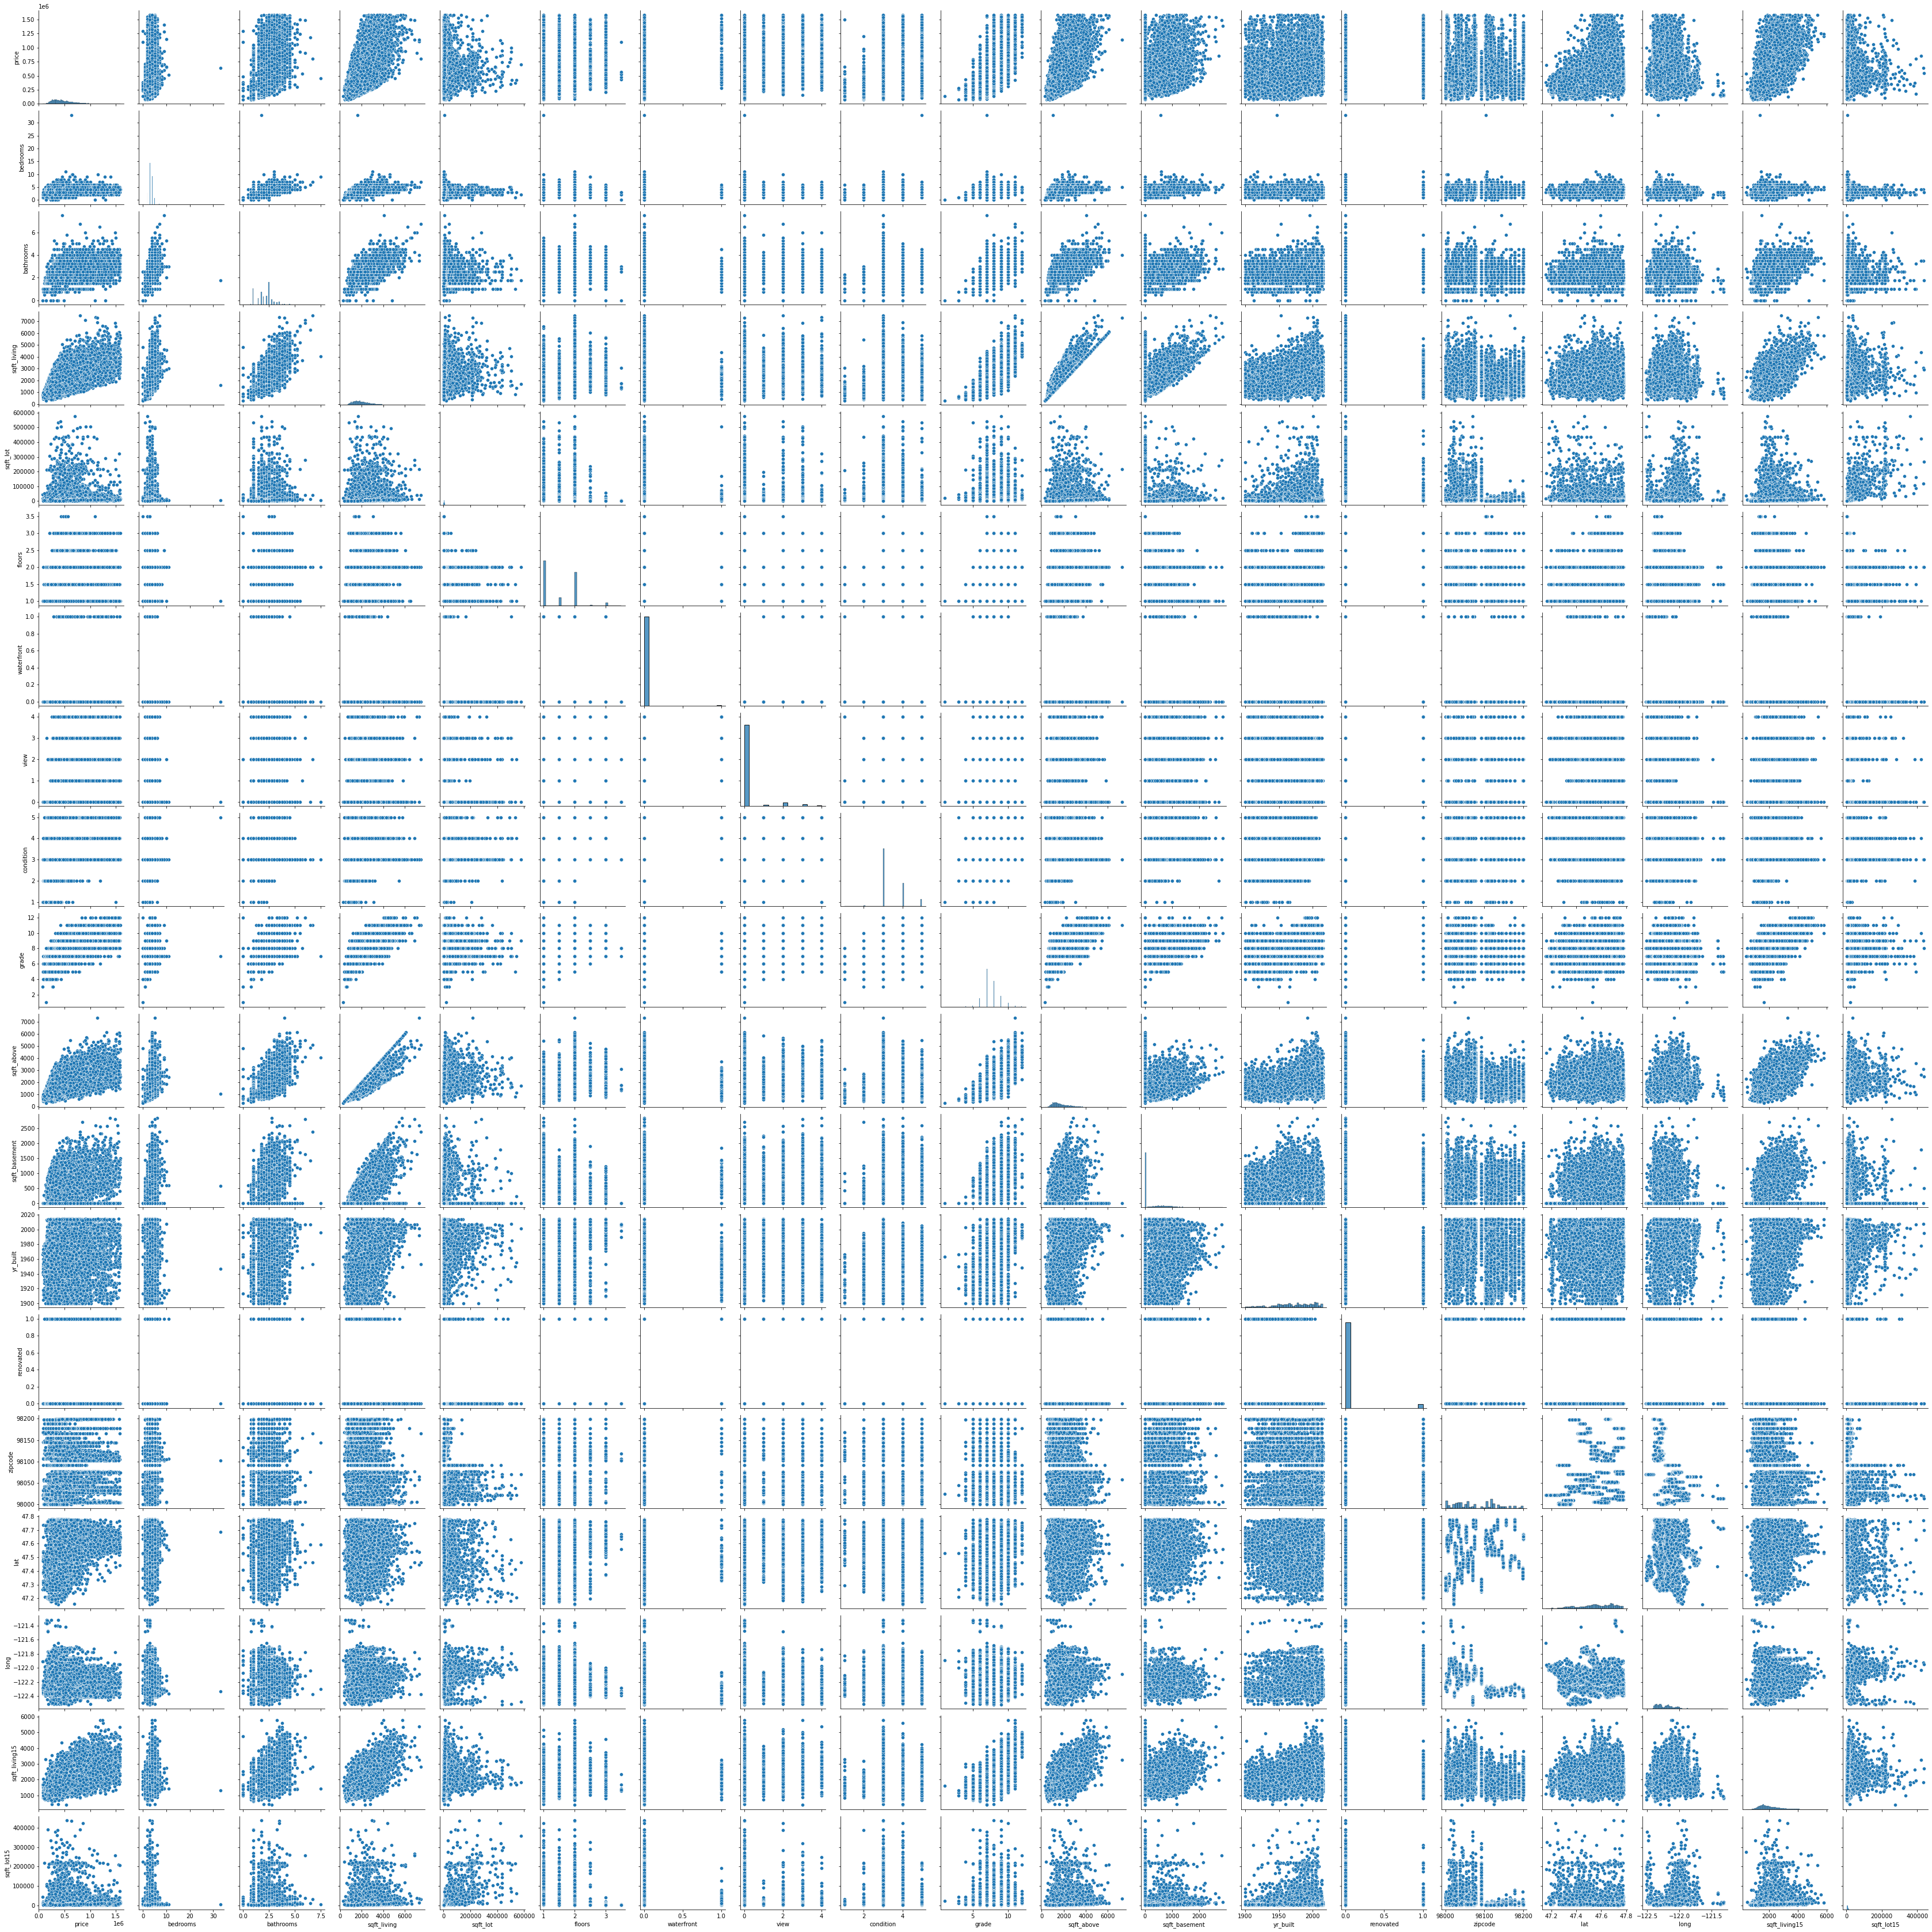

In [26]:
# print an overview of the data relation with every pair of features
sns.pairplot(data)

as longitud tends to decrease, that is go west, in King county, there appears to be more houses, and particularly houses with higher price. Similarly with the latitud as it increases, that means, as the house is more to the north, there are more houses with high price in the King County area in washington state.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='long', ylabel='price'>

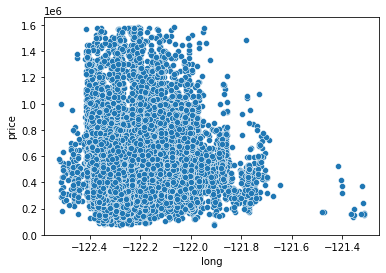

In [27]:
sns.scatterplot(data['long'], data['price'])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='lat', ylabel='price'>

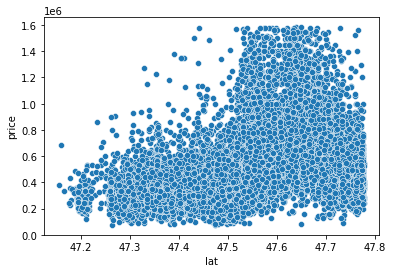

In [28]:
sns.scatterplot(data['lat'], data['price'])

# Building and fitting the model

In [29]:
X = data.drop('price', axis=1)
y = data['price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=0)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14805, 18)
(6345, 18)
(14805,)
(6345,)


In [32]:
params = {'iterations':10000,
        'learning_rate':0.01,
        'depth':3,
        'loss_function':'RMSE',
        'eval_metric':'RMSE',
        'random_seed':55,
        #'cat_features':boston_categories,
        'metric_period':200,  
        'od_type':"Iter",  
        'od_wait':20,  
        'verbose':True,
        'use_best_model':True}
model = CatBoostRegressor(**params)

# Training model

In [33]:
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True,
         plot=True,
         verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 255525.1286652	test: 247190.0812399	best: 247190.0812399 (0)	total: 59.6ms	remaining: 9m 55s
200:	learn: 141908.3402748	test: 138671.6929676	best: 138671.6929676 (200)	total: 424ms	remaining: 20.6s
400:	learn: 120117.1584657	test: 118317.0868781	best: 118317.0868781 (400)	total: 762ms	remaining: 18.2s
600:	learn: 109732.0587931	test: 108743.9862069	best: 108743.9862069 (600)	total: 1.1s	remaining: 17.3s
800:	learn: 104370.9583605	test: 103910.3975764	best: 103910.3975764 (800)	total: 1.51s	remaining: 17.4s
1000:	learn: 100952.7343922	test: 100881.1522657	best: 100881.1522657 (1000)	total: 1.86s	remaining: 16.7s
1200:	learn: 98078.5948083	test: 98508.8723391	best: 98508.8723391 (1200)	total: 2.21s	remaining: 16.2s
1400:	learn: 95921.2574847	test: 96816.9455131	best: 96816.9455131 (1400)	total: 2.56s	remaining: 15.7s
1600:	learn: 94343.4786285	test: 95572.7723753	best: 95572.7723753 (1600)	total: 2.9s	remaining: 15.2s
1800:	learn: 92912.7455917	test: 94471.6936633	best: 94471.6

# Metrics: Evaluating the model

$R^2$: compares models prediction to the mean of the targets. that is the expected value

In [34]:
# predictions on the test set
y_pred = model.predict(X_test)

print('MAE: ',mean_absolute_error(y_test,y_pred)) # sum(abs(y_test - y_pred) / len(y_test))
print('MSE: ',mean_squared_error(y_test,y_pred)) # sum((y_test - y_pred)**2 / len(y_test))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('R^2 score', model.score(X_test,y_test)) # Calculates r^2


MAE:  57643.119607081106
MSE:  7272683491.6081705
RMSE:  85280.02985229409
R^2 score 0.8822450762060576


# Computing SHAP values

In [35]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test[:100])

In [36]:
print('Shape', np.shape(shap_values))

sample_id = 0
shap_values[sample_id]

Shape (100, 18)


.values =
array([  -282.61288928,   8144.16822759,  22244.45872251, -16413.26153277,
        -5116.23906329,  -2235.65993626,  -6182.76105294,  -8090.77117932,
        14093.46418298,  11045.06437987,   4511.47457338,  -4536.48607738,
        -1372.11646747,  -3711.76375117,  59608.19717122,  -7424.54336186,
        16224.03249865,   1442.36313771])

.base_values =
508172.6875211732

.data =
array([ 4.00000e+00,  3.00000e+00,  2.32000e+03,  4.46800e+03,
        2.00000e+00,  0.00000e+00,  0.00000e+00,  3.00000e+00,
        8.00000e+00,  2.16000e+03,  1.60000e+02,  1.99900e+03,
        0.00000e+00,  9.80290e+04,  4.75460e+01, -1.22009e+02,
        2.33000e+03,  3.54100e+03])

## Efficiency property & Local Accuracy

- How to get the SHAP Explainer model's prediction
$$\hat{f}(X) = \phi_0 + \sum_{i=1}^{M}\phi_i$$


- This is the same as the equation from the Efficiency property:
$$\phi_0 = E(\hat{f}(X))$$
$$\sum_{i=1}^{M}\phi_i = \hat{f}(x)-E(\hat{f}(X))$$


- It goes to say that the Explainer model's prediction equals to the original model prediction (**Local Accuracy**):
$$\hat{f}(x) = g(x') = \phi_0 + \sum_{i=1}^{M}\phi_i$$

In [37]:
y_test.iloc[0]
y_pred = shap_values[sample_id].base_values+sum(shap_values[sample_id].values)
print('y_test', y_test.iloc[0])
print('explainer model pred', y_pred)
print('original model pred', model.predict(X_test.iloc[sample_id]))

y_test 637500.0
explainer model pred 590119.6951033478
original model pred 590119.6951033483


In [38]:
shap.initjs()
shap.force_plot(shap_values[sample_id,:], X_test.iloc[sample_id,:])

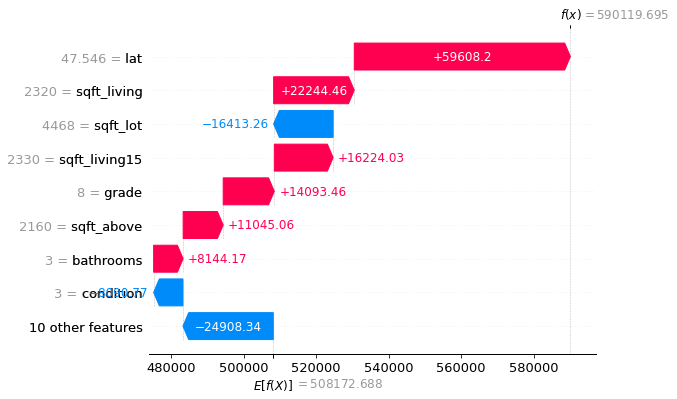

In [39]:
shap.plots.waterfall(shap_values[sample_id], max_display=9)

## Global scope

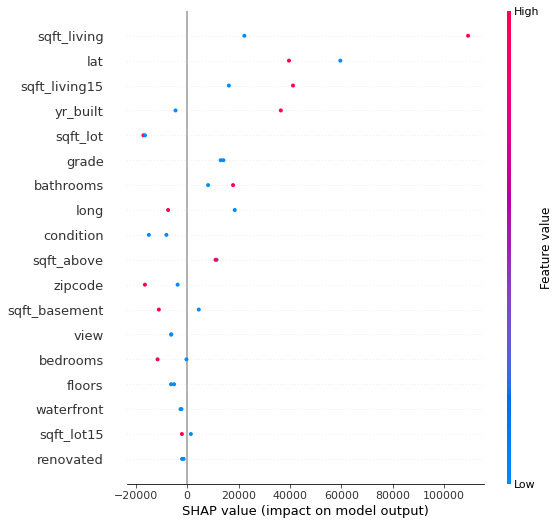

In [40]:
shap.summary_plot(shap_values[:2], X_test[:2], max_display=np.shape(X_test)[1])

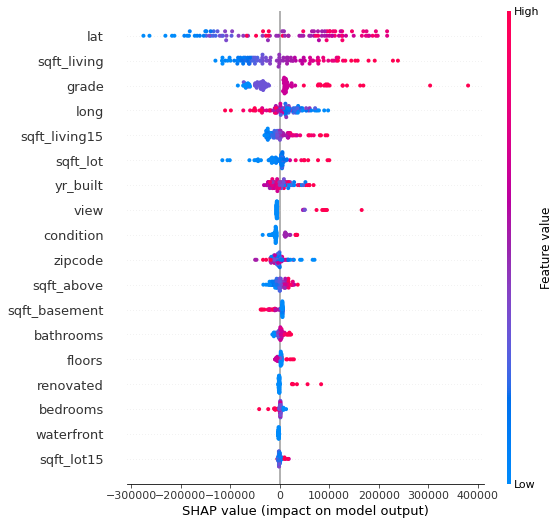

In [41]:
shap.summary_plot(shap_values, X_test[:100], max_display=np.shape(X_test)[1])

## Computing global scope shap values
$M \rightarrow$ number of background samples
$$\text{Global }\phi_i = \frac{1}{M}\sum_{j=1}^{M}|\phi_i^{(j)}|$$

In [42]:
# computing global scope shapley values
df = dict()
for i in range(np.shape(shap_values)[1]):
    df[X_test.columns[i]] = [abs(shap_values.values[:,i]).mean()]

df_pd = pd.DataFrame(data=df).T
df_pd.columns = ['mean(|SHAP|)']
df_pd.sort_values(by='mean(|SHAP|)', ascending=False)

mean(|SHAP|)
lat            111808.324530
sqft_living     67291.859993
grade           50281.208691
long            29829.861053
sqft_living15   19580.390788
sqft_lot        18335.128080
yr_built        17203.426984
view            14668.023259
condition       12032.061944
zipcode         10872.472298
sqft_above      10637.328254
sqft_basement    7719.815693
bathrooms        5665.552992
floors           4000.778990
renovated        3874.257222
bedrooms         3179.590270
waterfront       2277.659072
sqft_lot15       2265.687505

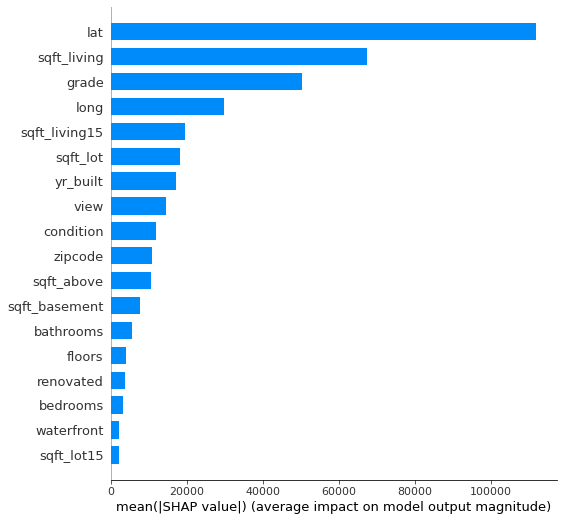

In [43]:
shap.summary_plot(shap_values, X_test[:100],plot_type="bar", max_display=np.shape(X_test)[1]) 

## Dummy property

- If $val(S \cup \{x_i\} = val(S))$, then $\phi_i = 0$

In [44]:
feature = 'waterfront'
coalition = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']


val_s_i = get_val(model, X_test[:100], X_test[0:1], coalition + [feature])
val_s = get_val(model, X_test[:100], X_test[0:1], coalition)
print('val_s_i = ', val_s_i)
print('val_s = ', val_s)
print('phi_i = ', val_s_i - val_s)

val_s_i =  28038.99209383132
val_s =  28038.99209383132
phi_i =  0.0


In [45]:
X_test['waterfront'][:100].value_counts()

0    100
Name: waterfront, dtype: int64